In [1]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset

2024-03-21 14:57:44.403388: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 14:57:44.403508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 14:57:44.525572: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
df_org= pd.read_excel("/kaggle/input/testdataset/26K_Bangla_Multi_class_Emotion.xlsx")

df_org = df_org.sample(frac=1.0, random_state=42)

df_org.head()

,TEXT,classes
22518,"কমেন্ট পড়তে আসলাম, আর দেখলাম ডিজিটাল বাংলাদেশে...",anger
24865,আমি মনে করি আমি জিনিসগুলি তৈরি করতে সহজেই বিক্...,anger
26058,ভাই আমাকে আরও একবার ক্লাসের একটি মেয়ে বানাত...,surprise
14068,আমি আমার বেতনের কাজ এবং পারিবারিক জীবনকে ভারসা...,joy
1588,আমার স্বপ্নগুলোতে দেয়ালে জমে থাকা শেওলার মত শে...,sadness


In [4]:
labels = df_org['classes'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['anger', 'surprise', 'joy', 'sadness', 'disgust', 'fear']

In [5]:
for key, value in enumerate(labels):
    print(value)

anger
surprise
joy
sadness
disgust
fear


In [7]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [8]:
label2id

{'anger': 0, 'surprise': 1, 'joy': 2, 'sadness': 3, 'disgust': 4, 'fear': 5}

In [9]:
id2label

{0: 'anger', 1: 'surprise', 2: 'joy', 3: 'sadness', 4: 'disgust', 5: 'fear'}

In [10]:
df_org.head()

,TEXT,classes
22518,"কমেন্ট পড়তে আসলাম, আর দেখলাম ডিজিটাল বাংলাদেশে...",anger
24865,আমি মনে করি আমি জিনিসগুলি তৈরি করতে সহজেই বিক্...,anger
26058,ভাই আমাকে আরও একবার ক্লাসের একটি মেয়ে বানাত...,surprise
14068,আমি আমার বেতনের কাজ এবং পারিবারিক জীবনকে ভারসা...,joy
1588,আমার স্বপ্নগুলোতে দেয়ালে জমে থাকা শেওলার মত শে...,sadness


In [12]:
df_org["labels"]=df_org.classes.map(lambda x: label2id[x.strip()])

In [13]:
df_org.head(30)

,TEXT,classes,labels
22518,"কমেন্ট পড়তে আসলাম, আর দেখলাম ডিজিটাল বাংলাদেশে...",anger,0
24865,আমি মনে করি আমি জিনিসগুলি তৈরি করতে সহজেই বিক্...,anger,0
26058,ভাই আমাকে আরও একবার ক্লাসের একটি মেয়ে বানাত...,surprise,1
14068,আমি আমার বেতনের কাজ এবং পারিবারিক জীবনকে ভারসা...,joy,2
1588,আমার স্বপ্নগুলোতে দেয়ালে জমে থাকা শেওলার মত শে...,sadness,3
5214,আমি বেশিরভাগই আশ্চর্যজনক অনুভব করছি যে আমি সফট...,joy,2
5814,"অত্যন্ত লজ্জার বিষয়, আবার বাংলা লোকসংস্কৃতির ...",disgust,4
14341,আমি তার স্ত্রীর বিলোপ মামলা সম্পর্কে জিজ্ঞাসা ...,anger,0
19319,আমি মনে করি এবং এটি কিছুটা অদ্ভুত মনে হয়,fear,5
24448,আমি উদ্বিগ্ন যে ভেরিজোনকে বিশ্বাস না করার বিষয...,joy,2


<Axes: ylabel='count'>

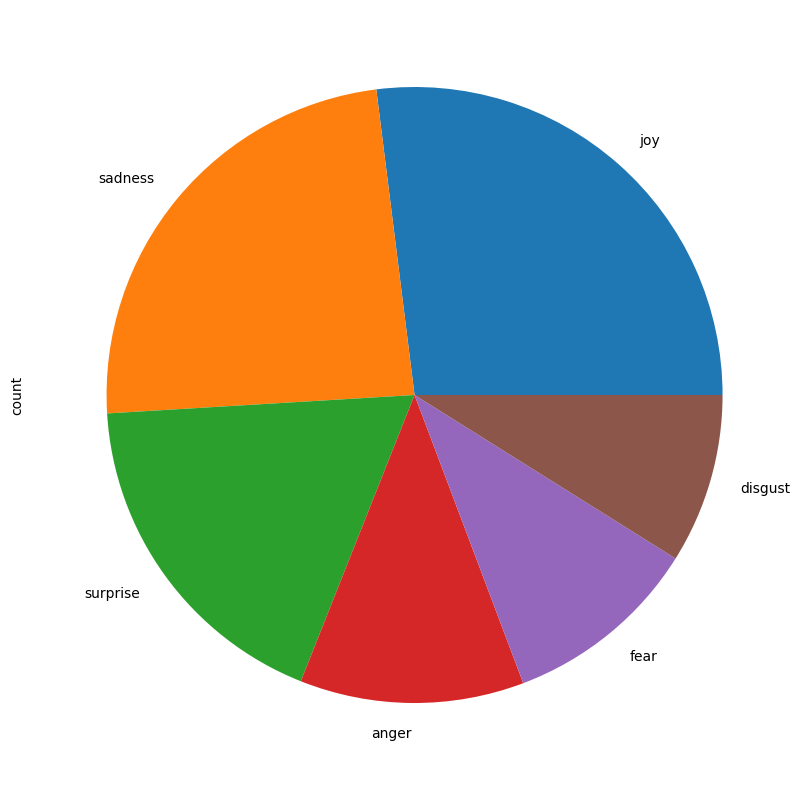

In [14]:
df_org.classes	.value_counts().plot(kind='pie', figsize=(10,10))

In [15]:
tokenizer = BertTokenizerFast.from_pretrained("sagorsarker/bangla-bert-base", max_length=512)

vocab.txt:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

In [16]:
model = BertForSequenceClassification.from_pretrained("sagorsarker/bangla-bert-base", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

model.safetensors:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(102025, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [17]:
SIZE= df_org.shape[0]

train_texts= list(df_org.TEXT[:SIZE//2])

val_texts=   list(df_org.TEXT[SIZE//2:(3*SIZE)//4 ])

test_texts=  list(df_org.TEXT[(3*SIZE)//4:])

train_labels= list(df_org.labels[:SIZE//2])

val_labels=   list(df_org.labels[SIZE//2:(3*SIZE)//4])

test_labels=  list(df_org.labels[(3*SIZE)//4:])

In [18]:
len(train_texts)

13180

In [19]:
len(train_texts), len(val_texts), len(test_texts)

(13180, 6590, 6591)

In [20]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [21]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)

In [22]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

In [23]:
from transformers import TrainingArguments, Trainer

In [24]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.
    
    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of 
              that observation belonging to a certain class.
              
    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids
    
    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)
    
    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    
    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)
    
    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [25]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='/kaggle/working/TTC4900Model', 
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0 
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,                
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory                 
    logging_dir='./kaggle/working/multi-class-logs',            
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps", 
    fp16=True,
    load_best_model_at_end=True
)

In [26]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned 
    model=model,
     # training arguments that we defined above                        
    args=training_args,                 
    train_dataset=train_dataloader,         
    eval_dataset=val_dataloader,            
    compute_metrics= compute_metrics
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [27]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.688100,1.529104,0.377238,0.299626,0.392521,0.357443
100,1.438700,1.354504,0.449014,0.349456,0.407336,0.397798
150,1.402200,1.304240,0.491502,0.414088,0.485831,0.471319
200,1.270200,1.248188,0.502428,0.476218,0.589989,0.472152
250,1.219500,1.139425,0.555690,0.533835,0.536448,0.553487
300,1.143200,1.102035,0.573445,0.540505,0.577429,0.560595
350,1.112200,1.053098,0.610167,0.563539,0.634051,0.560153
400,1.018900,1.006498,0.638543,0.609758,0.649651,0.599912
450,1.053000,1.165040,0.581487,0.500002,0.691396,0.488525
500,0.989700,0.972126,0.658270,0.631574,0.640788,0.637974


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=2472, training_loss=0.6992650481489484, metrics={'train_runtime': 3411.6965, 'train_samples_per_second': 11.59, 'train_steps_per_second': 0.725, 'total_flos': 6827483749443840.0, 'train_loss': 0.6992650481489484, 'epoch': 3.0})

In [28]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.396386,0.870106,0.855193,0.863700,0.852555
val,0.796176,0.733687,0.711251,0.723027,0.709899
test,0.748923,0.743590,0.719317,0.729259,0.717670


In [29]:
def predict(text):
    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].

    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """

    # Get the index of the class with the highest probability
    # argmax() finds the index of the maximum value in the tensor along a specified dimension.
    # By default, if no dimension is specified, it returns the index of the maximum value in the flattened tensor.
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label 
    # Since pred_label_idx is a tensor containing a single value (the predicted class index), 
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [30]:
# Test with a an example text in Turkish
text = "আমার ব্যথাগুলো আমারই থাক অশ্রুতে দুটি চোখ যায় ভরে যাক।"
# "Machine Learning itself is moving towards more and more automated"
predict(text)

(tensor([[0.0127, 0.0275, 0.0130, 0.6098, 0.0015, 0.3355]], device='cuda:0',
        grad_fn=<SoftmaxBackward0>),
 tensor(3, device='cuda:0'),
 'sadness')

In [31]:
model_path = "/kaggle/working/verse-text-classification-model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !


('/kaggle/working/verse-text-classification-model/tokenizer_config.json',
 '/kaggle/working/verse-text-classification-model/special_tokens_map.json',
 '/kaggle/working/verse-text-classification-model/vocab.txt',
 '/kaggle/working/verse-text-classification-model/added_tokens.json',
 '/kaggle/working/verse-text-classification-model/tokenizer.json')

In [32]:
model_path = "/kaggle/working/verse-text-classification-model"

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [44]:
nlp("কেন সে ভালোবাসে না..আমি দুঃখিত")

[{'label': 'sadness', 'score': 0.9727894067764282}]